# Homework 4 (100 Points)

## Exercise 1 (40pts)

In this exercise we will implement a Natural Language Processing (NLP) system using binary logistic regression.

The data you will be working with comes from the [Yelp Dataset](https://www.yelp.com/dataset). Each line is a review that consists of a label (0 for negative reviews and 1 for positive reviews) and a set of words.

```
1 i will never forget this single breakfast experience in mad...
0 the search for decent chinese takeout in madison continues ...
0 sorry but me julio fell way below the standard even for med...
1 so this is the kind of food that will kill you so there s t...
```

In order to transform the set of words into vectors, we will rely on a method of feature engineering called word embeddings. Rather than simply indicating which words are present, word embeddings represent each word by "embedding" it in a low-dimensional vector space which may carry more information about the semantic meaning of the word. (for example in this space, the words "King" and "Queen" would be close).

`word2vec.txt` contains the `word2vec` embeddings for about 15 thousand words. Not every word in each review is present in the provided `word2vec.txt` file. We can treat these words as being "out of vocabulary" and ignore them.

### Example

Let x_i denote the sentence `“a hot dog is not a sandwich because it is not square”` and let a toy word2vec dictionary be as follows:

```
hot      0.1     0.2     0.3
not      -0.1    0.2     -0.3
sandwich 0.0     -0.2    0.4
square   0.2     -0.1    0.5
```

we would first `trim` the sentence to only contain words in our vocabulary: `"hot not sandwich not square”` then embed x_i into the feature space:

$$ φ2(x_i)) = \frac{1}{5} (word2vec(\text{hot}) + 2 · word2vec(\text{not}) + word2vec(\text{sandwich}) + word2vec(\text{square})) = \left[0.02 \hspace{2mm} 0.06 \hspace{2mm} 0.12 \hspace{2mm}\right]^T $$

### Part 1 (20pts)

a) Implement a function to trim out-of-vocabulary words from the reviews. Your function should return an nd array of the same dimension and dtype as the original loaded dataset. (10pts)

In [95]:
import csv
import numpy as np

VECTOR_LEN = 300   # Length of word2vec vector
MAX_WORD_LEN = 64  # Max word length in dict.txt and word2vec.txt

################################################################################
# We have provided you the functions for loading the tsv and txt files. Feel   #
# free to use them! No need to change them at all.                             #
################################################################################


def load_tsv_dataset(file):
    """
    Loads raw data and returns a tuple containing the reviews and their ratings.

    Parameters:
        file (str): File path to the dataset tsv file.

    Returns:
        An np.ndarray of shape N. N is the number of data points in the tsv file.
        Each element dataset[i] is a tuple (label, review), where the label is
        an integer (0 or 1) and the review is a string.
    """
    dataset = np.loadtxt(file, delimiter='\t', comments=None, encoding='utf-8',
                         dtype='l,O')
    return dataset


def load_feature_dictionary(file):
    """
    Creates a map of words to vectors using the file that has the word2vec
    embeddings.

    Parameters:
        file (str): File path to the word2vec embedding file.

    Returns:
        A dictionary indexed by words, returning the corresponding word2vec
        embedding np.ndarray.
    """
    word2vec_map = dict()
    with open(file) as f:
        read_file = csv.reader(f, delimiter='\t')
        for row in read_file:
            word, embedding = row[0], row[1:]
            word2vec_map[word] = np.array(embedding, dtype=float)
    return word2vec_map


def trim_reviews(path_to_dataset):
    dataset = load_tsv_dataset(path_to_dataset)
    word2vec_map = load_feature_dictionary('./data/word2vec.txt')
    trimmed_dataset = np.empty_like(dataset)
    # Trim words and create embeddings for each review
    for i, (label, review) in enumerate(dataset):
        words = review.split()
        words = [word for word in words if word in word2vec_map]
        # if all words are out-of vocabulary, skip this loop
        if not words:
            continue
        # Compute review embedding
        embedding = np.zeros(VECTOR_LEN)
        for word in words:
            embedding += word2vec_map[word]
        embedding /= len(words)
        # Store result in trimmed_dataset
        trimmed_dataset[i] = (label, embedding)
    # Remove all unused entries in trimmed_dataset
    trimmed_dataset = trimmed_dataset[:i+1]
    return trimmed_dataset

trim_train = trim_reviews("./data/train_small.tsv")
trim_test = trim_reviews("./data/test_small.tsv")

print(trim_train[:1])
print(trim_test[:1])

[(1, array([-1.66646018e-01,  6.41026549e-01, -6.48053097e-02,  1.79902655e-01,
         7.58946903e-01, -9.67097345e-01, -1.19115044e+00, -2.29079646e-01,
         4.17796460e-01,  1.16079646e-01, -5.54292035e-01,  4.63389381e-01,
        -6.91079646e-01,  8.20955752e-01, -3.17469027e-01,  2.93513274e-01,
        -1.19477876e+00, -5.07362832e-01, -4.45681416e-01,  1.53669912e+00,
        -1.40284956e+00,  1.29318584e+00,  2.06079646e-01,  6.46132743e-01,
         5.21061947e-01,  1.71594690e+00, -1.31963717e+00,  2.26681416e-01,
        -2.65699115e-01, -4.27716814e-01, -7.03017699e-01, -1.09171681e+00,
        -7.33920354e-01, -8.85557522e-01,  1.50001770e+00,  1.64640708e+00,
         1.72471681e+00, -1.06955752e+00,  1.22292035e+00, -1.80577876e+00,
        -8.64893805e-01, -6.76991150e-03,  9.33628319e-03, -1.12483186e+00,
        -2.40803540e+00, -1.14992920e+00, -6.69646018e-02,  1.16514159e+00,
        -1.54790265e+00,  1.29176991e-01,  9.91371681e-01, -1.10922124e+00,
        

b) Implement the embedding and store it to a `.tsv` file where the first column is the label and the rest are the features from the embedding. Round all numbers to 6 decimal places. `embedded_train_small.tsv` and `embedded_test_small.tsv` contain the expected output of your function. (10pts)

In [96]:
def embed_reviews(trimmed_dataset):
    # Create a new nd array to store the embedded dataset
    embedded_dataset = np.empty((len(trimmed_dataset), VECTOR_LEN+1), dtype=float)
    # Embed each review and store it in the new dataset
    for i, (label, embedding) in enumerate(trimmed_dataset):
        # Store the label in the first column
        embedded_dataset[i, 0] = label
        # Store the embedding in the rest of the columns
        embedded_dataset[i, 1:] = embedding
    return embedded_dataset

def save_as_tsv(dataset, filename):
    # Round all numbers to 6 decimal places
    dataset = np.round(dataset, decimals=6)
    # Convert the dataset to a list of lines
    lines = [('\t'.join(str(elem) for elem in row) + '\n') for row in dataset]
    with open(filename, 'w+') as f:
        f.writelines(lines)
    return

embedded_train = embed_reviews(trim_train)
embedded_test = embed_reviews(trim_test)

save_as_tsv(embedded_train, "./data/output/embedded_train_small.tsv")
save_as_tsv(embedded_test, "./data/output/embedded_test_small.tsv")

### Part 2 (20pts)

In this part we'll be implementing Gradient Descent for binary Logistic Regression Classifier.

Some rules:

1. Include an intercept term in your model. You must consider the bias term as part of the weight vector and not a separate term to keep track of.
2. Initialize all model parameters to 0
3. Use vector and matrix multiplication

The expected `metrics.txt` from the dataset with `500` epochs and `0.001` learning rate is:

```
error(train): 0.000000
error(test): 0.625000
```

We will be testing your code on other, larger datasets.

In [97]:
import numpy as np

def load_tsv_dataset(file):
    return np.loadtxt(file, delimiter='\t', encoding='utf-8')

def sigmoid(x):
    return 1/(1 + np.exp(-x))

def gd(theta, X, y, learning_rate):
    y_pred = sigmoid(np.dot(X, theta))
    grad = np.dot(X.T, y_pred - y)
    theta -= learning_rate * grad
    return theta

def train(theta, X, y, num_epochs, learning_rate):
    for i in range(num_epochs):
        theta = gd(theta, X, y, learning_rate)
    return theta

def predict(theta, X):
    y_pred = sigmoid(np.dot(X, theta))
    # Classify as 1 if y_pred >= 0.5, 0 otherwise
    return (y_pred >= 0.5).astype(int)

def compute_error(y_pred, y):
    return np.mean(y_pred != y)

def write_metrics(train_err, test_err, metrics_out):
    with open(metrics_out, 'w+') as f:
        w = "error(train): " + "{:.6f}".format(train_err) + "\n"
        w += "error(test): " + "{:.6f}".format(test_err) + "\n"
        f.write(w)
    return

def logistic_reg(formatted_train, formatted_test, metrics_out, num_epochs, learning_rate):
    train_data = load_tsv_dataset(formatted_train)
    test_data = load_tsv_dataset(formatted_test)
    
    X = np.insert(train_data[:, 1:], 0, 1, axis=1)
    y = train_data[:, 0]
    X_test = np.insert(test_data[:, 1:], 0, 1, axis=1)
    y_test = test_data[:, 0]
    theta = np.zeros(X.shape[1])
    
    learned_theta = train(theta, X, y, num_epochs, learning_rate)
    train_pred = predict(learned_theta, X)
    train_err = compute_error(train_pred, y)
    test_pred = predict(learned_theta, X_test)
    test_err = compute_error(test_pred, y_test)

    write_metrics(train_err, test_err, metrics_out)
    return


logistic_reg("./data/output/embedded_train_small.tsv", "./data/output/embedded_test_small.tsv", "./data/output/metrics.txt", 500, 0.01)

## Exercise 2 (60 Points)

For this exercise, recall the lab's kaggle competition where you predicted if a cookie was defective or not (assuming you attend labs). For more information on the data and details, [click here to view the competition and data details](https://www.kaggle.com/competitions/cs506-lab-defective-cookie-detection/data)

However, what we will do differently here is check if two of the features were correlated. This is important because if two features are correlated, then we can remove one of the features and still get the same information. This is part of the feature selection process.

### Loading in the Data

For this exercise, we are interested in the two features `Texture Hardness` and `Texture Chewiness` and want to see if they are related. To do this, we will load in the data and create a scatter plot of the two features.

**a)** (1 Point) Download the kaggle data from the link above and read in the `csv` files `cookie_train.csv` and `cookie_test.csv`

In [98]:
import pandas as pd
import matplotlib.pyplot as plt
train_data = pd.read_csv("./data/Exercise2/cookie_train.csv")
test_data = pd.read_csv("./data/Exercise2/cookie_test.csv")

### Combining Training and Testing Data

The lab did not have a lot of cookies for the training set, so what we will do is combine the training and testing data together without any loss of generality.

**b)** (3 Point) Combine the training and testing data together into a single dataframe called `cookie_data` and plot the scatter plot for `Texture Chewiness` (our y or our response variable) and `Texture Hardness` (our x or our explanatory variable). Make sure to label your axes and give your plot a title.

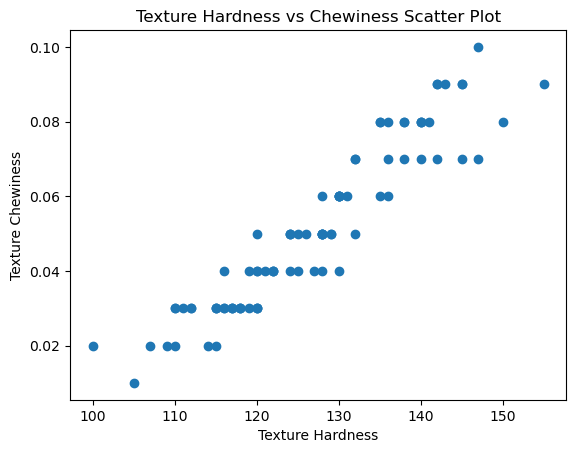

In [99]:
cookie_data = pd.concat([train_data, test_data], ignore_index=True)
plt.scatter(cookie_data["Texture Hardness"], cookie_data["Texture Chewiness"])
plt.xlabel("Texture Hardness")
plt.ylabel("Texture Chewiness")
plt.title("Texture Hardness vs Chewiness Scatter Plot")
plt.show()

### Checking If We Can Do Linear Regression

It is important to check all requirements/assumptions for linear regression are met before we do linear regression. One of the requirements is that the explanatory variable and response variable are linearly related, which we checked by noticing the scatter plot was linear. However, there is much more to check!

#### Checking for Normality
It is important to check that the response variable is normally distributed. This is important for hypothesis testing and relates to the idea of linear regression being an unbiased, minimum variance estimator (if you're interested in this, check out the course CAS MA 582).


**c) (5 Points)** Plot an appropriate graph to determine if the response variable `Texture Chewiness` follows the normality assumption. State whether the normality assumption is met or not. If it is not met, state what can we do to fix this.

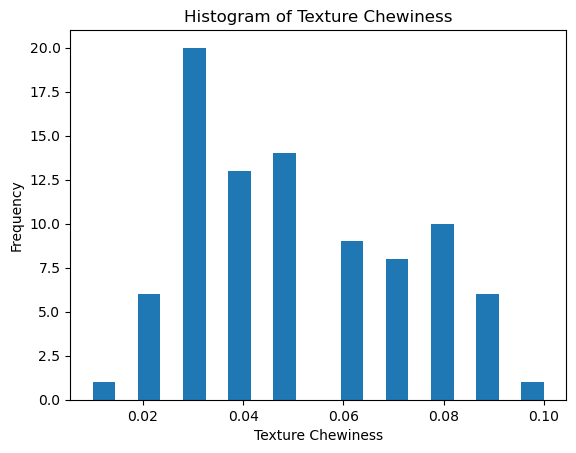

In [100]:
# histogram of Texture Chewiness
plt.hist(cookie_data["Texture Chewiness"], bins=20)
plt.xlabel("Texture Chewiness")
plt.ylabel("Frequency")
plt.title("Histogram of Texture Chewiness")
plt.show()

_(Written response goes in this cell)_

Based on the histogram, Texture Chewiness is basically normally distributed. Normality assumption is approximately met.

#### Checking for Homoscedasticity
It is important to check that the variance of the response variable is the same across all values of the explanatory variable. Otherwise, the confidence around a predicted value of the response variable will vary depending on the explanatory variable value.

**d) (5 Points)** Plot an appropriate graph to determine if the response variable `Texture Chewiness` follows the homoscedasticity assumption. State whether the homoscedasticity assumption is met or not. If it is not met, state what can we do to fix this.

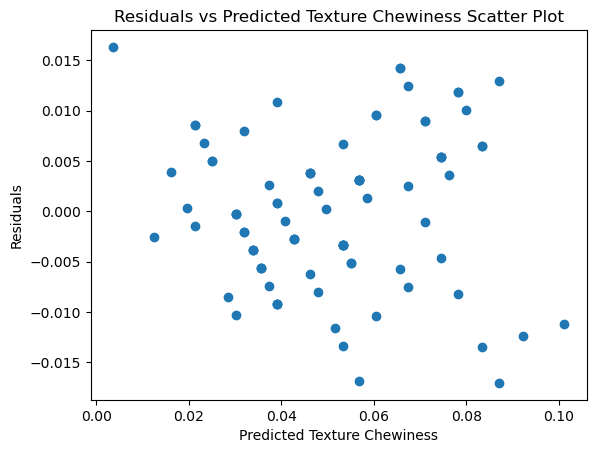

In [101]:
from sklearn.linear_model import LinearRegression
X = cookie_data[["Texture Hardness"]]
y = cookie_data["Texture Chewiness"]
model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)

plt.scatter(y_pred, y - y_pred)
plt.xlabel("Predicted Texture Chewiness")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted Texture Chewiness Scatter Plot")
plt.show()

_(Written response goes in this cell)_

The variance of the residuals is roughly constant across all values of the predicted Texture Chewiness, so the homoscedasticity assumption is met.

#### Checking for Independence
It is important to check that the explanatory variable and response variable are independent. Otherwise, the model isn't really best fit with a line. To do so, we will use the Durbin-Watson test.

**e) (5 Points)** Use the Durbin-Watson test to determine if the explanatory variable and response variable are independent. State whether if the independence assumption is met or not. If it is not met, state what can we do to fix this. You may use any library to do this, and for more information, check out [this link](https://www.investopedia.com/terms/d/durbin-watson-statistic.asp).

In [102]:
import statsmodels.api as sm
X = cookie_data[["Texture Hardness"]]
y = cookie_data["Texture Chewiness"]
model = sm.OLS(y, sm.add_constant(X)).fit()
# Durbin-Watson test on residuals
dw_test = sm.stats.stattools.durbin_watson(model.resid)

print("Durbin-Watson test statistic: {:.2f}".format(dw_test))

Durbin-Watson test statistic: 2.28


_(Written response goes in this cell)_

The test statistic is close to 2, then we can assume that the independence assumption is met.

#### Adjusting the Model
If you think any of the assumptions are not met, then you should respectively fix the model.

**f) (6 Points)** If you think atleast one of the assumptions were not met, then adjust the model how you described you would. Otherwise, proceed to the next step and in the cell below, write "No adjustments were made to the model". However, if you do adjust the model, then in the cell below, justify why your adjustments is appropriate (i.e. plot the new graphs and statistics found above). You may add as many cells as you like.

#Code in this cell

No adjustments were made to the model

No adjustments were made to the model

### Hypothesis Testing
Now that we have a model that is appropriate, we can do hypothesis testing. We will be using the Linear Regression t-test to test if the explanatory variable is a significant predictor of the response variable.

**g) (5 Points)** Use the Linear Regression t-test to determine if the explanatory variable `Texture Hardness` is a significant predictor of the response variable `Texture Chewiness`. State whether if the explanatory variable is a significant predictor of the response variable or not using an alpha significance level of $\alpha = 0.05$, the null hypothesis $\beta_{hardness} = 0$ and alternative hypothesis $\beta_{hardness} \neq 0$. If it is not, state what can we do to fix this. You may use any library to do this.

In [103]:
X = cookie_data[["Texture Hardness"]]
y = cookie_data["Texture Chewiness"]
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())
print()
print("p-value for Texture Hardness coefficient:", model.params["Texture Hardness"], 
      model.pvalues["Texture Hardness"])

                            OLS Regression Results                            
Dep. Variable:      Texture Chewiness   R-squared:                       0.879
Model:                            OLS   Adj. R-squared:                  0.878
Method:                 Least Squares   F-statistic:                     625.0
Date:                Mon, 10 Apr 2023   Prob (F-statistic):           3.27e-41
Time:                        06:55:35   Log-Likelihood:                 305.19
No. Observations:                  88   AIC:                            -606.4
Df Residuals:                      86   BIC:                            -601.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.1736      0.009  

_(Written response goes in this cell)_

3.27049621578656e-41 is smaller than alpha significance level $\alpha=0.05$.

### Adding a New Feature
Now that we have determined that the explanatory variable is a significant predictor of the response variable, you noticed the fit isn't 100% perfect still (e.g. your model is not capturing all the variation in the data). You think that there is another feature that can help improve the model. You think that the feature `Taste Sweetness` can help improve your model. You want to test if this is true. You may assume that all the assumptions are met for this new model to conduct linear regression.

**h) (10 Points)** Now that you have two features to predict your response variable, you will have to use multiple linear regression. Use the `statsmodels` library to do multiple linear regression. Then, determine if the explanatory variables `Texture Hardness` and `Taste Sweetness` are significant predictors of the response variable `Texture Chewiness` using an alpha significance level of $\alpha = 0.001$, the null hypothesis $\beta_{hardness} = 0$ and $\beta_{sweetness} = 0$ and alternative hypothesis $\beta_{hardness} \neq 0$ and $\beta_{sweetness} \neq 0$. If it is not, state what can we do to fix this. You may use any library to do this.

Moreover, justify whether the overall model is significant or not using the F-test with the same $\alpha$ given above. If it is not, state what can we do to fix this.

_You may use the transformed model made (if one was made) from the previous parts and add this new feature to it._

In [104]:
X = cookie_data[["Texture Hardness", "Taste Sweetness"]]
y = cookie_data["Texture Chewiness"]
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())
print()

print("p-value for Texture Hardness coefficient:", model.params["Texture Hardness"], model.pvalues["Texture Hardness"])
print("p-value for Taste Sweetness coefficient:", model.params["Taste Sweetness"], model.pvalues["Taste Sweetness"])
print()

f_test = model.f_test("Texture Hardness = 0, Taste Sweetness = 0")
print("F-statistic:", f_test)
print("p-value:", f_test.pvalue)

                            OLS Regression Results                            
Dep. Variable:      Texture Chewiness   R-squared:                       0.929
Model:                            OLS   Adj. R-squared:                  0.928
Method:                 Least Squares   F-statistic:                     560.2
Date:                Mon, 10 Apr 2023   Prob (F-statistic):           1.13e-49
Time:                        06:55:37   Log-Likelihood:                 328.93
No. Observations:                  88   AIC:                            -651.9
Df Residuals:                      85   BIC:                            -644.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.1096      0.011  

_(Written response goes in this cell)_

p-value: 1.1308085781938765e-49 is smaller than 0.001, so both Texture Hardness and Taste Sweetness are significant predictors of Texture Chewiness.

### Interpretation
It is important to be able to interpret the results of the model. This is important because it allows us to understand the model and how it works. It also allows us to understand the relationship between the predictors and the response variable, and this applies to not just linear regression, but all learning models.

**i) (10 Points)** Interpret the coefficients of the model made in part **h**. What do they mean? What do they represent? What do they tell us about the relationship between the predictors and the response variable? If your code output in part h does not provide these results, you are welcome to use any library here to do so.

In [105]:
#Your code in this cell if you need it

_(Written response goes in this cell)_

The model's coefficients indicate the change in the mean of the response variable (Texture Chewiness) for a one-unit shift in the predictor variable, while all other predictors remain constant.

The coefficient for Texture Hardness is 0.0011, implying that for every unit increase in Texture Hardness, the mean value of Texture Chewiness increases by 0.0011, with Taste Sweetness held constant.
And, the coefficient for Taste Sweetness is 0.0107, indicating that a one-unit increase in Taste Sweetness leads to a 0.0107 increase in the mean value of Texture Chewiness, while Texture Hardness is constant.

The p-values linked with each coefficient indicate whether the coefficients are statistically important. In this scenario, both coefficients have a p-value less than 0.001, implying that the null hypothesis that the corresponding coefficient is zero can be declined. As a result, both Texture Hardness and Taste Sweetness are considered significant predictors of Texture Chewiness.

In general, the multiple linear regression model indicates that both Texture Hardness and Taste Sweetness are significant predictors of Texture Chewiness, and the model can account for a significant amount of variance in the data (R-squared = 0.929).

### Using Taste Bitterness over Taste Sweetness
You think that the feature `Taste Bitterness` can help improve your model since `Taste Sweetness` wasn't it.

For this section, you will continue to use your fixed/adjusted features for `Texture Hardness` and `Texture Chewiness`.

**j) (10 Points)** Plot 2 scatter plots: `Taste Bitterness` vs your possibly adjusted `Texture Chewiness` and `Taste Bitterness` vs your possibly adjusted `Texture Hardness`. Given these plots, propose an appropriate model. Justify your answer by fitting it and seeing its accuracy (you can use any metric to prove so), showing appropriate models/graphs, and ensuring assumptions are satisfied (if any). You may use any library to do this.

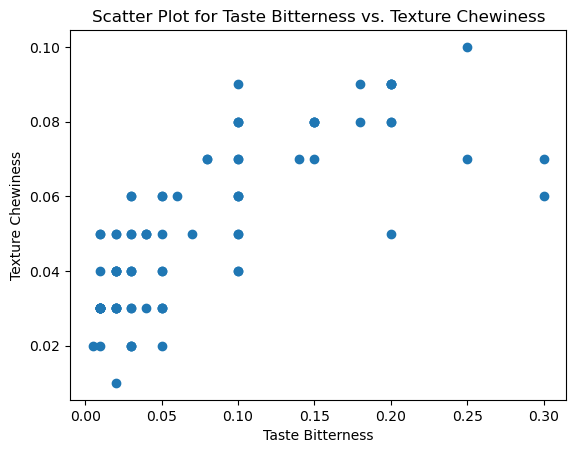

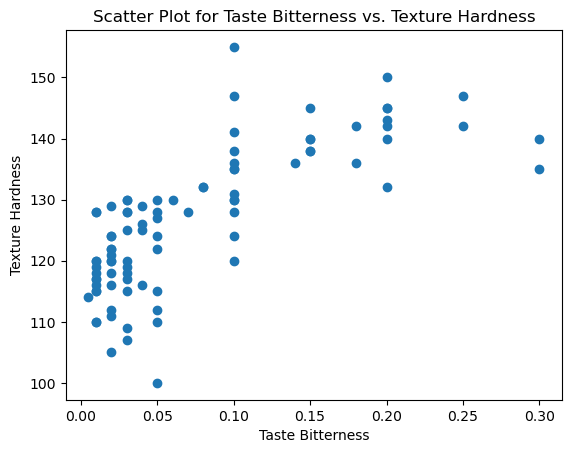

In [106]:
plt.scatter(cookie_data["Taste Bitterness"], cookie_data["Texture Chewiness"])
plt.xlabel("Taste Bitterness")
plt.ylabel("Texture Chewiness")
plt.title("Scatter Plot for Taste Bitterness vs. Texture Chewiness")
plt.show()

plt.scatter(cookie_data["Taste Bitterness"], cookie_data["Texture Hardness"])
plt.xlabel("Taste Bitterness")
plt.ylabel("Texture Hardness")
plt.title("Scatter Plot for Taste Bitterness vs. Texture Hardness")
plt.show()

In [107]:
X = sm.add_constant(cookie_data[["Texture Hardness", "Taste Bitterness"]])
y = cookie_data["Texture Chewiness"]
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:      Texture Chewiness   R-squared:                       0.887
Model:                            OLS   Adj. R-squared:                  0.885
Method:                 Least Squares   F-statistic:                     334.3
Date:                Mon, 10 Apr 2023   Prob (F-statistic):           5.25e-41
Time:                        06:55:42   Log-Likelihood:                 308.27
No. Observations:                  88   AIC:                            -610.5
Df Residuals:                      85   BIC:                            -603.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.1522      0.012  

## Bonus (20pts)

Lasso Regression is a modification of Regression that adds a regularization penalty to the the parameter $\mathbf{\beta}$ learned by the model. The loss function for Lasso is the following:

$$\mathcal{L}(\mathbf{\beta}) = \Vert \mathbf{y} - X\mathbf{\beta} \Vert^2 + \lambda \Vert \mathbf{\beta} \Vert = \beta^T X^T X \beta - 2\mathbf{\beta}^TX^T\mathbf{y}  + \mathbf{y}^T\mathbf{y} + \lambda \Vert \mathbf{\beta} \Vert$$

Where $\lambda$ is a tuning parameter specified by the user.

Using worksheet 17 as a guide:

1. create an animation like in part c) for Lasso Regression. [15pts]
2. create at least two more animations using different values for $\lambda$ and the true $\mathbf{\beta}$ you used to generate the dataset (try steeper / less steep curves, and higher or close to zero intercepts). Briefly explain some key takeaways on how to tune $\lambda$. [5pts]

In [80]:
from PIL import Image as im

def lasso_gradient(X, y, beta_hat, learning_rate, epochs, l1_penalty, images):
    losses = [lasso_loss(X, y, beta_hat, l1_penalty)]
    betas = [beta_hat]
    for _ in range(epochs):
        images.append(snap_model(beta_hat))
        lasso_grad = lasso_gradient_vec(X, y, beta_hat, l1_penalty)
        beta_hat = beta_hat - learning_rate * lasso_grad
        losses.append(lasso_loss(X, y, beta_hat, l1_penalty))
        betas.append(beta_hat)
    return np.array(betas), np.array(losses)

def lasso_loss(X, y, beta, l1_penalty):
    n = len(y)
    y_pred = X @ beta
    residuals = y - y_pred
    rss = np.sum(residuals**2)
    l1_norm = np.sum(np.abs(beta))
    return rss/n + l1_penalty*l1_norm

def lasso_gradient_vec(X, y, beta_hat, l1_penalty):
    n = len(y)
    y_pred = X @ beta_hat
    residuals = y - y_pred
    grad = -2 * X.T @ residuals / n
    l1_grad = l1_penalty * np.sign(beta_hat)
    return grad + l1_grad

def snap_model(beta):
    xplot = np.linspace(-10,10,50)
    yestplot = beta[0] + beta[1] * xplot
    fig, ax = plt.subplots()
    ax.plot(xplot, yestplot,'b-',lw=2)
    ax.plot(X[:, 1], y, 'ro', markersize=4)
    ax.set_xlim(-10, 10)
    ax.set_ylim(min(y), max(y))
    fig.savefig(TEMPFILE)
    plt.close()
    return im.fromarray(np.asarray(im.open(TEMPFILE)))

TEMPFILE = "./data/bonus/temp.png"

n = 100
x = np.linspace(-10, 10, n)
y = 2*x + 3 + np.random.normal(0, 2, n)
X = np.column_stack((np.ones(n), x))
beta_start = np.zeros(2)
learning_rate = 0.002
epochs = 1000
l1_penalty = 0.5

images = []
betas, losses = lasso_gradient(X, y, beta_start, learning_rate, epochs, l1_penalty, images)

images[0].save(
    './data/bonus/lasso_model2.gif',
    optimize=False,
    save_all=True,
    append_images=images[1:],
    loop=0,
    duration=200
)

In [93]:
n = 100
x = np.linspace(-10, 10, n)
y = 2*x + 3 + np.random.normal(0, 2, n)
X = np.column_stack((np.ones(n), x))
beta_start = np.zeros(2)
learning_rate = 0.002
epochs = 1000
l1_penalty = 5 # higher lambda

images = []
betas, losses = lasso_gradient(X, y, beta_start, learning_rate, epochs, l1_penalty, images)

images[0].save(
    './data/bonus/lasso_model_lambda5.gif',
    optimize=False,
    save_all=True,
    append_images=images[1:],
    loop=0,
    duration=200
)

In [94]:
n = 100
x = np.linspace(-10, 10, n)
y = 2*x + 3 + np.random.normal(0, 2, n)
X = np.column_stack((np.ones(n), x))
beta_start = np.zeros(2)
learning_rate = 0.002
epochs = 1000
l1_penalty = 0.001 # lower lambda

images = []
betas, losses = lasso_gradient(X, y, beta_start, learning_rate, epochs, l1_penalty, images)

images[0].save(
    './data/bonus/lasso_model_lambda0.001.gif',
    optimize=False,
    save_all=True,
    append_images=images[1:],
    loop=0,
    duration=200
)

The regularization parameter $\lambda$ controls the trade-off between the bias and the variance of the model. A high value of $\lambda$ will heavily penalize the coefficients and may set some of them to exactly zero, leading to underfitting of the data. This is especially true if the true underlying model is complex and requires many non-zero coefficients to capture. In contrast, a low value of $\lambda$ will not effectively shrink the coefficients towards zero, and the model may overfit the data. This is especially true if the true underlying model is simple and requires only a few non-zero coefficients to capture.

In [87]:
n = 100
x = np.linspace(-10, 10, n)
y = 10*x + 0.1 + np.random.normal(0, 2, n)  # 10, 0.1
X = np.column_stack((np.ones(n), x))
beta_start = np.zeros(2)
learning_rate = 0.002
epochs = 1000
l1_penalty = 0.1

images = []
betas, losses = lasso_gradient(X, y, beta_start, learning_rate, epochs, l1_penalty, images)

images[0].save(
    './data/bonus/lasso_model_10x+0.1.gif',
    optimize=False,
    save_all=True,
    append_images=images[1:],
    loop=0,
    duration=200
)

In [88]:
n = 100
x = np.linspace(-10, 10, n)
y = 0.5*x + 1 + np.random.normal(0, 2, n)  # 0.5, 1
X = np.column_stack((np.ones(n), x))
beta_start = np.zeros(2)
learning_rate = 0.002
epochs = 1000
l1_penalty = 0.1

images = []
betas, losses = lasso_gradient(X, y, beta_start, learning_rate, epochs, l1_penalty, images)

images[0].save(
    './data/bonus/lasso_model_0.5x+1.gif',
    optimize=False,
    save_all=True,
    append_images=images[1:],
    loop=0,
    duration=200
)